# TRANSFER FUNCTIONS FOR CLOSED LOOP SYSTEMS

This notebook discusses how to create a transfer function for a closed loop including analysis of the resulting transfer function. The analysis focuses on first order open loop systems, open loops with a single pole and no zero.

# Preliminaries

In [1]:
#!pip install -q control
#!pip install -q controlSBML
import numpy as np
import control
import controlSBML as ctl
import pandas as pd
import matplotlib.pyplot as plt
import sympy
import tellurium as te
ctl.__version__

'1.2.4'

# Helpers

In [2]:
TIMES = np.linspace(0, 10, 100)

In [3]:
def plotStep(tf, is_plot=True):
    """
    Plots the step response of the transfer function.

    Args:
        tf - transfer function
    """
    times, yv = control.step_response(tf)
    plt.plot(times, yv)
    if not is_plot:
        plt.close()

# TESTS
tf = control.TransferFunction([1], [1, 1])
plotStep(tf, is_plot=False)
print("OK!")

OK!


# Models

## SEQUENTIAL MODEL

Sequential reaction network

\begin{eqnarray}
S_1 & \xrightarrow{k_1 x_1} & S_2 \\
S_2 & \xrightarrow{k_2 x_2} & S_3 \\
S_3 & \xrightarrow{k_3 x_3} & \emptyset \\
\end{eqnarray}

Derived *open loop* transfer function for the sequential model
\begin{eqnarray}
G(s) & = & \frac{X_3(s)}{X_1(s)} \\
& = & \frac{k_2 k_1 }{(s + k_3)(s + k_2)} \\
\end{eqnarray}

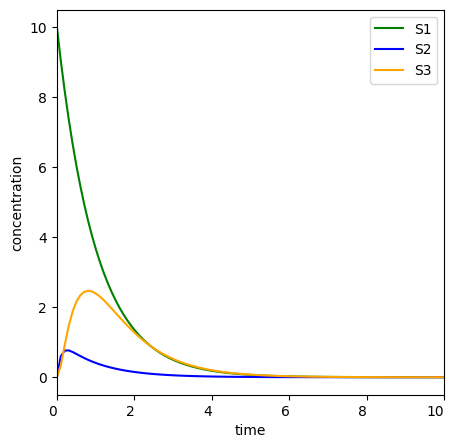

In [4]:
SEQUENTIAL_MODEL = """
model *model_main()
J1: S1 -> S2; k1*S1
J2: S2 -> S3; k2*S2
J3: S3 -> ; k3*S3
S1 = 10; S2 = 0; S3 = 0

k1 = 1
k2 = 10
k3 = 2
end
"""
SEQUENTIAL_CTLSB = ctl.ControlSBML(SEQUENTIAL_MODEL, times=TIMES,
        input_name="S1", output_name="S3")
_ = SEQUENTIAL_CTLSB.plotModel()

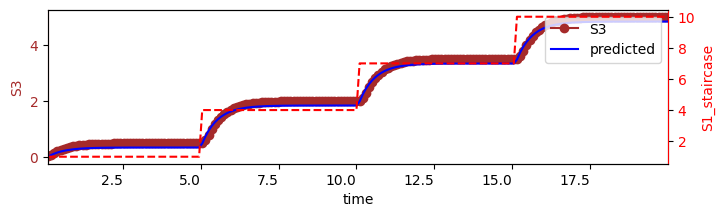


     0.4584
-----------------
0.4561 s + 0.9212

[-2.01973725+0.j]


In [5]:
# Fit with one pole
# Fit with one pole
result = SEQUENTIAL_CTLSB.plotTransferFunctionFit(num_zero=0, num_pole=1,
            initial_value=1, final_value=10, num_step=3,
            times=np.linspace(0, 20, 200), figsize=(8, 2))
SEQUENTIAL_TF = result.transfer_function
print(SEQUENTIAL_TF)
print(SEQUENTIAL_TF.poles())

## Wolf

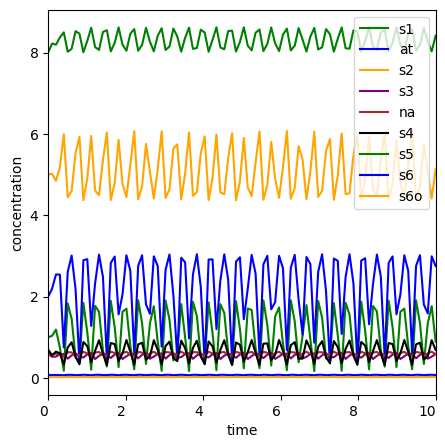

In [6]:
ctlsb = ctl.ControlSBML("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000206.2?filename=BIOMD0000000206_url.xml", 
                        input_name="at", output_name="s5")
_ = ctlsb.plotModel()

# Transfer Functions for PID Controller

The controllers considered here are systems that input the control error and produce a control signal used
to regulate the system under control.
The input signal is $e(t)$ and the output signal is $u(t)$.

## P Controller

A **proportional controller** has the parameter $k_P$.
This controller outputs a signal that is proportional to the control error.
That is, for this system, the input $u(t)$ is the control error and the output $y(t)$ is the control input to the OLS.

**State and Output Equations**
1. There is no state, and so there is no state equation.
1. Output equation: $y(t) = k_P u(t)$.

**Laplace Transforms**
1. $Y(s) = k_P U(s)$

**Transfer Functions**
1. $G_P(s) = \frac{Y(s)}{U(s)} = k_P$

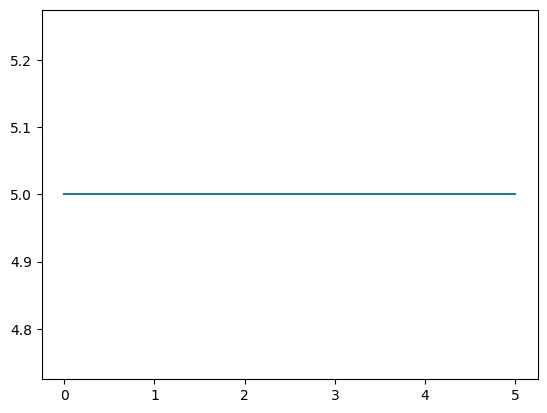

In [8]:
# Construct the transfer function
kP = 5
tf = control.TransferFunction([kP], [1])
plotStep(tf)

## I Controller

An **integral controller** has the parameter $k_I$.
This controller outputs a signal that is proportional to the *integral* of the control error.
That is, $u(t) = k_I \int_0^{t} e(\tau) d \tau$.
The transfer function for this controller is $H_{I} (s) = \frac{k_I}{s}$.

**State and Output Equations**
1. The state $x(t) = \int_0^{t} u(\tau) d \tau$.
1. Output equation: $y(t) = k_I x(t)$.

**Laplace Transforms**
1. $Y(s) = \frac{k_I}{s} U(s)$

**Transfer Functions**
1. $G_I(s) = \frac{Y(s)}{U(s)} = \frac{k_I}{s}$

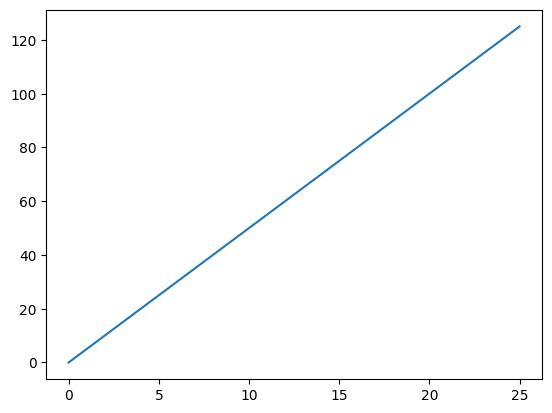

In [11]:
# Construct the transfer function
kI = 5
gi_tf = control.TransferFunction([kI], [1, 0])
plotStep(gi_tf)

## D Controller

An **differential controller** has the parameter $k_D$.
This controller outputs a signal that is proportional to the derivative of the control error.

**State and Output Equations**
1. The state $x(t) = \frac{d u(t)}{d t}$.
1. Output equation: $y(t) = k_D x(t)$.

**Laplace Transforms**
1. $Y(s) = s k_D U(s)$

**Transfer Functions** 
1. $G_D(s) = \frac{Y(s)}{U(s)} = k_D s$

In [12]:
# Construct the transfer function
kD = 5
# The following would cause an error because the transfer function is not "proper",
# That is, the numerator degree exceeds the degree of the denominator.
tf = control.TransferFunction([kD, 0], [1])
tf/control.TransferFunction.s

TransferFunction(array([5, 0]), array([1, 0]))

## PID Controller

<img src="https://raw.github.com/joseph-hellerstein/advanced-controls-lectures/main/lectures/images/pid_control.png"
     alt="Markdown Monster icon" 
     width="600" height="750"
     style="float: left; margin-right: 10px;" />

PID control is the sum of the effects of the individual controllers.

$y_{PID}(t)$ is the sum of the signals output by the P, I, and D controllers.
So, $Y_{PID}(s)$ is the sum of these signals.
That is:
\begin{eqnarray}
Y_{PID} (s) & = & Y_P(s) + Y_I (s) + Y_D (s)\\
\end{eqnarray}

* The transfer function for the P controller is $G_P(s) = \frac{Y_P(s)}{U(s)}  = k_P$.
* The transfer function for  I controller is $G_I(s) = \frac{Y_I(s)}{U(s)} =  \frac{k_I}{s}$.
* The transfer function for  D controller is $G_D(s) = \frac{Y_D(s)}{U(s)} = k_D s$.

\begin{eqnarray}
G_{PID} (s) & = & \frac{Y_{PID}(s)}{U(s)} \\
& = & \frac{Y_P (s) + Y_I (s) + Y_D (s)}{U(s)} \\
& = & G_P (s) + G_I (s) + G_D (s) \\
& = & k_P + \frac{k_I}{s} + k_D s\\
& = & \frac{ k_I + k_P s + k_D s^2}{s} \\
\end{eqnarray}

# Closed Loop Transfer Functions

<img src="https://raw.github.com/joseph-hellerstein/advanced-controls-lectures/main/lectures/images/closed_loop_system.png"
     alt="Markdown Monster icon" 
     width="600" height="750"
     style="float: left; margin-right: 10px;" />

The starting point for transfer function analysis is to identify the system or systems to
be analyzed.
Here, we only consider single input single output (SISO) systems.
So, we need to identify which input/output relationships are of interest.

| Input  | Output | Why of interest?        | Desired DC Gain | Desired poles |
|--------|--------|-------------------------|-----------------|---------------|
| $r(t)$ | $m(t)$ | convergence to set point| 1               | very negative |
| $n(t)$ | $m(t)$ | influence of noise      | 0               | very negative |
| $d(t)$ | $m(t)$ | influence of disturbance| 0               | very negative |
| $r(t)$ | $e(t)$ | convergence to set point| 0               | very negative |
| $n(t)$ | $e(t)$ | influence of noise      | 0               | very negative |
| $d(t)$ | $e(t)$ | influence of disturbance| 0               | very negative |

Our focus is the following simpler system and the transfer function $H(s) = \frac{Y(s)}{R(s)}$.

## Notation & definitions

<img src="https://raw.github.com/joseph-hellerstein/advanced-controls-lectures/main/lectures/images/simple_feedback_nofilter.png"
     alt="Markdown Monster icon" 
     width="400" height="500"
     style="float: left; margin-right: 10px;" />


| Element  | Time | Laplace  |
|--------------|--------|---------------------|
| Reference signal | $r(t)$ | $R(s)$ | 
| Error signal | $e(t)$ | $E(s)$ |
| Controller System| $c(t)$ | $C(s)$ |
 | Open loop system | $g(t)$ | $G(s)$ |
 | Measured output signal | $y(t)$ | $Y(s)$|

## Derivation

\begin{eqnarray}
H(s) & = & \frac{Y(s)}{R(s)} \\
Y(s) & = & E(s)C(s)G(s) \\
\cal{L}(e(t)) & = & \cal{L} ( r(t) - y(t)) \\
 & = & R(s) - Y(s) \\
\end{eqnarray}

\begin{eqnarray}
Y(s) & = & (R(s) - Y(s))C(s)G(s) \\
 & = & R(s)C(s)G(s) - Y(s)C(s)G(s) \\
Y(s)(1 + C(s)G(s)) & = &  R(s)C(s)G(s) \\
\frac{Y(s)}{R(s)} & = & \frac{C(s)G(s)}{1 + C(s)G(s)} \\
\end{eqnarray}

# P-Control

## Open loop step response

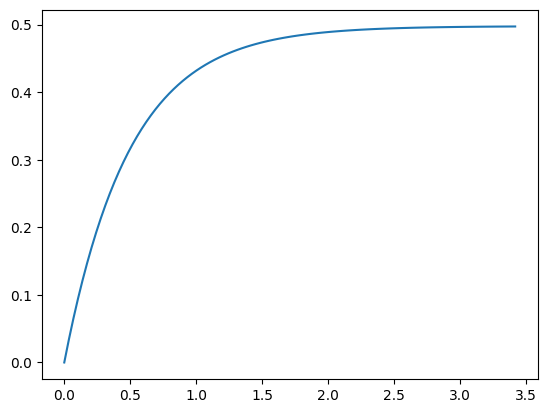

In [14]:
plotStep(SEQUENTIAL_TF)

## Closed loop step response

For p-control, $C(s) = k_P$.

The open loop system has a first order system has the transfer function $G(s) = \frac{k}{s + p}$.

\begin{eqnarray}
H(s) & = & \frac{C(s)G(s)}{1 + C(s)G(s)} \\
& = & \frac{k_P \frac{k}{s + p}}{1 + k_P \frac{k}{s + p}} \\
& = & \frac{k_P k }{s + p + k k_P} \\
\end{eqnarray}

**Questions**
* What are the poles of the closed loop transfer function?
* What is the DC Gain?
* How do settling times change as $k_P$ is increased?
* How does DC Gain changes as $k_P$ is increased?


    0.4584
---------------
0.4561 s + 1.38



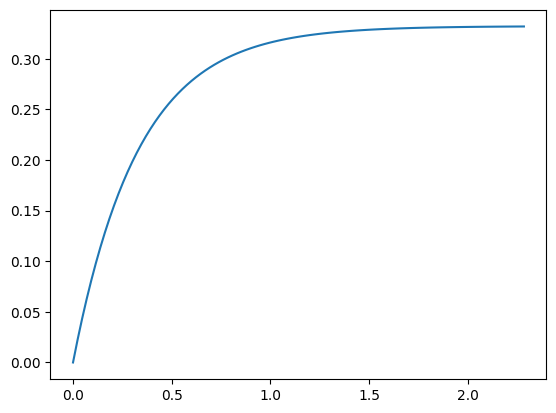

In [16]:
# Step response for SEQUENTIAL with p-control.
kp = 1
closed_tf = control.feedback(kp*SEQUENTIAL_TF)
print(closed_tf)
plotStep(closed_tf)

**Questions**
1. What happens to the poles as $k_P$ increases? What happens to dcgain?
2. Why might we *not* want a larger $k_P$?

The above behaviors only apply to first order systems. Second order systems are more complicated.

# PI Control

$C(s) = k_P + \frac{k_I}{s}$

The open loop system has a first order system has the transfer function $G(s) = \frac{k}{s + p}$.

\begin{eqnarray}
H(s) & = & \frac{C(s)G(s)}{1 + C(s)G(s)} \\
& = & \frac{ (k_P + \frac{k_I}{s}) \frac{k}{s + p}}{1 +  (k_P + \frac{k_I}{s}) \frac{k}{s + p}} \\
& = & \frac{kk_P s + k k_I}{s^2 + ps + kk_P s + k k_I} \\
\end{eqnarray}

We find the closed loop poles by solving the characteristic equation:
\begin{eqnarray}
0 & = & s^2 + ps + kk_P s + k k_I \\
s & = & \frac{1}{2} \left( -(p + k k_P ) \pm \sqrt{(p + k k_P)^2 - 4 k k_I} \right) \\
\end{eqnarray}

We minimize the dominant pole by making $k_P$ large and selecting $k_I$ such that
such that 
\begin{equation}
k_I = \frac{(p + k k_P)^2}{4k}
\end{equation}
so that the term in the square root is 0.


## Numerical study

In [17]:
kP = 200
controller_tf = control.TransferFunction([kP], [1]) + control.TransferFunction([kI], [1, 0])
controller_tf

TransferFunction(array([200,   5]), array([1, 0]))

In [18]:
closed_tf = control.feedback(controller_tf*SEQUENTIAL_TF)
closed_tf

TransferFunction(array([91.68052997,  2.29201325]), array([ 0.45608562, 92.60170309,  2.29201325]))

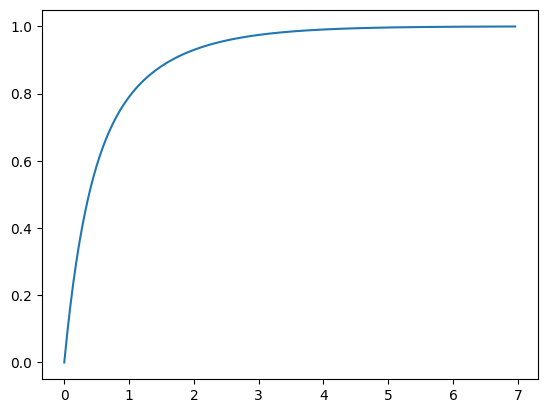

In [22]:
def evaluatePI(kP, kI, is_plot=True):
    controller_tf = control.TransferFunction([kP], [1]) + control.TransferFunction([kI], [1, 0])
    closed_tf = control.feedback(controller_tf*SEQUENTIAL_TF)
    plotStep(closed_tf)
    if not is_plot:
        plt.close()

#
evaluatePI(2, 3, is_plot=False)
print("OK")

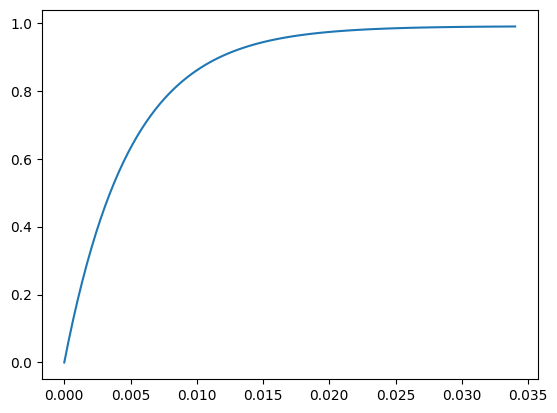

In [26]:
evaluatePI(kP=200, kI=10)

In [20]:
SEQUENTIAL_TF

TransferFunction(array([0.45840265]), array([0.45608562, 0.92117312]))

## Finding the best value for kI


In [21]:
k = 0.4584
p = np.real(SEQUENTIAL_TF.poles()[0])
kI = (p + k*kP)**2/(4*k)
kI

4384.251044676379